In [134]:
import jax.numpy as np

In [135]:
from jax import grad

In [136]:
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax
from jax import random

In [137]:
import matplotlib.pyplot as plt # visualization

In [138]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1, 1)
out_shape, net_params = net_init(rng, in_shape)

In [139]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

In [44]:
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

In [45]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)

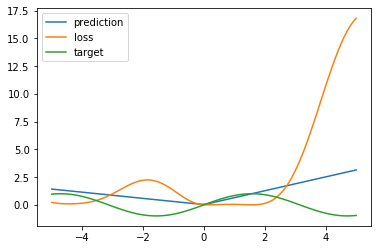

In [46]:
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [47]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap

In [48]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

In [49]:
@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(loss)(p, x1, y1)
    return opt_update(i, g, opt_state)

In [51]:
for i in range(100):
    opt_state = step(i, opt_state, xrange_inputs, targets)
net_params = get_params(opt_state)

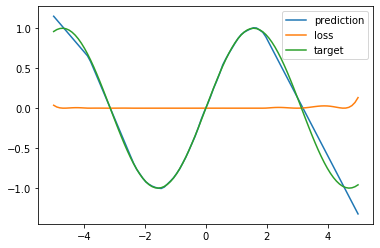

In [54]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [140]:
def inner_update(p, x1, y1, alpha=.1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [73]:
grad(maml_loss)

<function __main__.grad.<locals>.grad_f(p, x1, y1, x2, y2)>

In [57]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20

np_maml_loss = []

# Adam optimization
for i in range(20000):
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


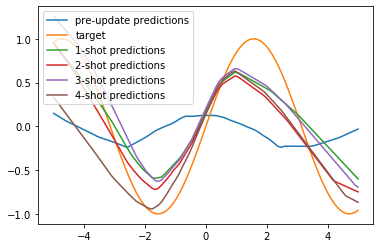

In [58]:
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

In [75]:
f = lambda x, y : np.exp(x + y)
g = lambda x : np.square(x)
print(grad(f)(1., 2.)) # = e^{1}
# print(grad(grad(f))(1.))
# print(grad(grad(grad(f)))(1.))

# print(grad(g)(2.)) # 2x = 4
# print(grad(grad(g))(2.)) # x = 2
# print(grad(grad(grad(g)))(2.)) # x = 0

20.085537


In [78]:
grad(f)(1., 2.)

DeviceArray(20.085537, dtype=float32)

In [72]:
grad(f)(3.)

DeviceArray(20.085537, dtype=float32)

In [141]:
# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

In [142]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

In [143]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [101]:
rng = random.PRNGKey(0)
input_shape = (-1, 1,)

In [97]:
def inner_update(p, x1, y1, alpha=.1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [98]:
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

In [99]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

In [105]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 1000 == 0:
        print(i, x1_b.shape,  l)
net_params = get_params(opt_state)

0 (4, 20, 1) 9.706549
1000 (4, 20, 1) 0.110699736
2000 (4, 20, 1) 0.019129574
3000 (4, 20, 1) 0.01683126
4000 (4, 20, 1) 0.006633825
5000 (4, 20, 1) 0.008860696
6000 (4, 20, 1) 0.008190389
7000 (4, 20, 1) 0.008366133
8000 (4, 20, 1) 0.0063006966
9000 (4, 20, 1) 0.0067491
10000 (4, 20, 1) 0.0034269898
11000 (4, 20, 1) 0.0041208332
12000 (4, 20, 1) 0.005654796
13000 (4, 20, 1) 0.004678022
14000 (4, 20, 1) 0.0076468294
15000 (4, 20, 1) 0.00412468
16000 (4, 20, 1) 0.005955161
17000 (4, 20, 1) 0.0032348158
18000 (4, 20, 1) 0.0022699044
19000 (4, 20, 1) 0.0024154224


## Find Average Sine curve

In [212]:
import numpy as onp
import matplotlib.pyplot as plt

In [213]:
amplitude_range = [0.1, 5.]
phase_range = [0., onp.pi]
block_sizes = [0.1, 0.1]
domain_bounds = [-5., 5.]
N = 1000

In [214]:
# mesh of equally partitioned state space
amplitude_spectrum, phase_spectrum = onp.mgrid[
    amplitude_range[0]:amplitude_range[1]:block_sizes[0],
    phase_range[0]:phase_range[1]:block_sizes[1]
    ]

parameter_space_tuples = onp.vstack((amplitude_spectrum.flatten(), phase_spectrum.flatten())).T

In [215]:
x_space = onp.linspace(domain_bounds[0], domain_bounds[1], N)

In [216]:
all_y_values = onp.empty(N)

In [217]:
for parameters in parameter_space_tuples:
    for x in range(len(x_space)):
        all_y_values[x] += parameters[0] * onp.sin(x_space[x] + parameters[1])

In [218]:
mean_y_values = all_y_values / len(parameter_space_tuples)

/Users/sebastianlee/Dropbox/Documents/Work/Hack/Environments/meta/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


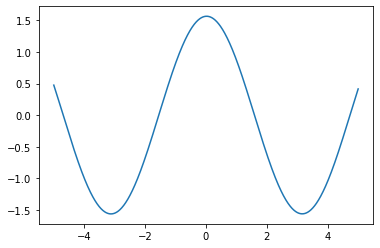

In [219]:
fig = plt.figure()
plt.plot(x_space, mean_y_values)
fig.show()

## MAML for Sine Regression

In [237]:
import jax.numpy as np

from jax import grad

from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax
from jax import random

In [238]:
rng = random.PRNGKey(0)
input_shape = (-1, 1,)

In [239]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1, 1)
out_shape, net_params = net_init(rng, in_shape)

In [240]:
def inner_update(p, x1, y1, alpha=.1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

In [241]:
def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [242]:
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

In [243]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=amplitude_range[0], high=amplitude_range[1]))
        phases.append(onp.random.uniform(low=phase_range[0], high=phase_range[1]))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=domain_bounds[0], high=domain_bounds[1], size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

In [244]:
@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

In [245]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

In [246]:
np_batched_maml_loss = []
K=20
for i in range(200000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 1000 == 0:
        print(i, x1_b.shape,  l)
net_params = get_params(opt_state)

0 (4, 20, 1) 26.247711
1000 (4, 20, 1) 2.9935417
2000 (4, 20, 1) 3.4100754
3000 (4, 20, 1) 2.7541833
4000 (4, 20, 1) 1.8586997
5000 (4, 20, 1) 1.0008874
6000 (4, 20, 1) 0.6665889
7000 (4, 20, 1) 0.9593241
8000 (4, 20, 1) 0.6071453
9000 (4, 20, 1) 0.45642555
10000 (4, 20, 1) 1.8760746
11000 (4, 20, 1) 1.2997869
12000 (4, 20, 1) 0.83456177
13000 (4, 20, 1) 1.246731
14000 (4, 20, 1) 0.5858729
15000 (4, 20, 1) 0.3790799
16000 (4, 20, 1) 0.9963531
17000 (4, 20, 1) 1.5355054
18000 (4, 20, 1) 0.3334719
19000 (4, 20, 1) 0.55478346
20000 (4, 20, 1) 0.7037729
21000 (4, 20, 1) 0.9947503
22000 (4, 20, 1) 1.1026883
23000 (4, 20, 1) 0.62443656
24000 (4, 20, 1) 0.23773527
25000 (4, 20, 1) 0.88637275
26000 (4, 20, 1) 0.61818576
27000 (4, 20, 1) 0.79298615
28000 (4, 20, 1) 1.3396351
29000 (4, 20, 1) 0.14304833
30000 (4, 20, 1) 0.8345517
31000 (4, 20, 1) 0.5340555
32000 (4, 20, 1) 0.3145738
33000 (4, 20, 1) 1.0525005
34000 (4, 20, 1) 0.6000089
35000 (4, 20, 1) 0.23073281
36000 (4, 20, 1) 0.88838303
3700

In [247]:
maml_y = net_apply(net_params, x_space.reshape(len(x_space), 1))

In [248]:
maml = [float(i[0]) for i in maml_y]

/Users/sebastianlee/Dropbox/Documents/Work/Hack/Environments/meta/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


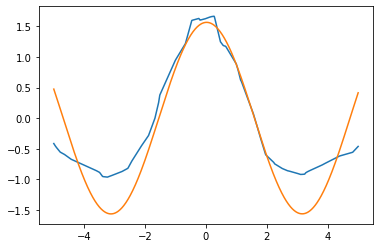

In [249]:
fig = plt.figure()
plt.plot(x_space, maml)
plt.plot(x_space, mean_y_values)
fig.show()